In [1]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
!rm -rf ./data/lab14/*

In [3]:
batch_size = 256

(xt, yt), (xv, yv) = mnist.load_data()
xt = xt.astype(float) / 255
# xt = np.expand_dims(xt, axis=-1)
xt = xt.reshape(-1, 28 * 28)

vis_z = np.random.uniform(-1, 1, (batch_size, 10))

def get_batch(data):
    indices = np.random.randint(0, len(data), (batch_size,))
    return data[indices]

In [4]:
def G(x):
    with tf.variable_scope('g', reuse=tf.AUTO_REUSE):
#         x = tf.layers.dense(x, 128)
#         x = tf.nn.leaky_relu(x)
#         x = tf.layers.dense(x, 49)
#         x = tf.nn.leaky_relu(x)
#         x = tf.reshape(x, [-1, 7, 7, 1])
#         x = tf.layers.conv2d_transpose(x, 32, kernel_size=(2, 2), strides=2)
#         x = tf.nn.leaky_relu(x)
#         x = tf.layers.conv2d_transpose(x, 64, kernel_size=(2, 2), strides=2)
#         x = tf.nn.leaky_relu(x)
#         x = tf.layers.conv2d(x, 1, kernel_size=(1, 1), padding='same')
#         x = tf.nn.sigmoid(x)
        x = tf.layers.dense(x, 256)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.dense(x, 512)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.dense(x, 28 * 28)
        x = tf.nn.sigmoid(x)
        return x


def D(x):
    with tf.variable_scope('d', reuse=tf.AUTO_REUSE):
#         x = tf.layers.conv2d(x, 32, kernel_size=(3, 3), strides=2, padding='same')
#         x = tf.nn.leaky_relu(x)
#         x = tf.layers.conv2d(x, 64, kernel_size=(3, 3), strides=2, padding='same')
#         x = tf.nn.leaky_relu(x)
#         x = tf.layers.flatten(x)
#         x = tf.layers.dense(x, 1)
        x = tf.layers.dense(x, 512)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.dense(x, 256)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.dense(x, 1)
        return x

In [5]:
# x_real = tf.placeholder(tf.float32, shape=[batch_size, 28, 28, 1])
x_real = tf.placeholder(tf.float32, shape=[batch_size, 28 * 28])
z_data = tf.placeholder(tf.float32, shape=[batch_size, 10])
x_fake = G(z_data)

# w = tf.random_uniform([batch_size, 1, 1, 1], minval=0.0, maxval=1.0)
w = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
x_fuse = w * x_real + (1.0 - w) * x_real

grad = tf.gradients(D(x_fuse), [x_fuse])[0]
# grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=(1, 2, 3)))
grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=(1)))
grad_penalty = 10 * tf.reduce_mean(tf.square(grad_norm - 1.0))

D_loss = tf.reduce_mean(D(x_real)) - tf.reduce_mean(D(x_fake)) + grad_penalty
G_loss = tf.reduce_mean(D(x_fake))

D_solver = tf.train.RMSPropOptimizer(1e-3, 0.5).minimize(D_loss, var_list=tf.trainable_variables('d'))
G_solver = tf.train.RMSPropOptimizer(1e-3, 0.5).minimize(G_loss, var_list=tf.trainable_variables('g'))

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

history = []
with tqdm(range(20_000)) as pbar:
    for step in pbar:
        for _ in range(5):
            _, loss_d = sess.run([D_solver, D_loss], feed_dict={
                x_real: get_batch(xt), 
                z_data: np.random.uniform(-1, 1, (batch_size, 10))
            })

        for _ in range(1):
            _, loss_g = sess.run([G_solver, G_loss], feed_dict={
                z_data: np.random.uniform(-1, 1, (batch_size, 10))
            })

        pbar.set_postfix({
            'D': loss_d,
            'G': loss_g
        })
        
        if step % 10 == 0:
            history.append({
                'step': step,
                'D': loss_d,
                'G': loss_g
            })

        if step % 500 == 0:        
            img = sess.run(x_fake, feed_dict={ z_data: vis_z })
            img = np.uint8(img * 255).reshape(-1, 28, 28)
            R, C = len(img) // 32, 32
            vis = np.zeros((R * 28, C * 28), dtype=np.uint8)
            for i, x in enumerate(img):
                r = i // 32 * 28
                c = i % 32 * 28
                vis[r:r+28, c:c+28] = x
            Image.fromarray(vis).save('./data/lab14/{:03d}.jpg'.format(step // 1000))

100%|██████████| 20000/20000 [03:23<00:00, 98.48it/s, D=-.531, G=3.18]  


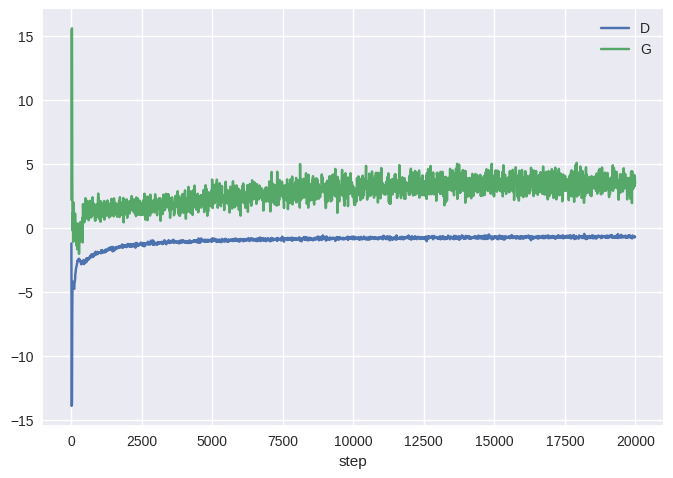

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd

df = pd.DataFrame(history)
fig, ax = plt.subplots(dpi=100)
df.plot(kind='line', x='step', y='D', ax=ax)
df.plot(kind='line', x='step', y='G', ax=ax)
plt.show()

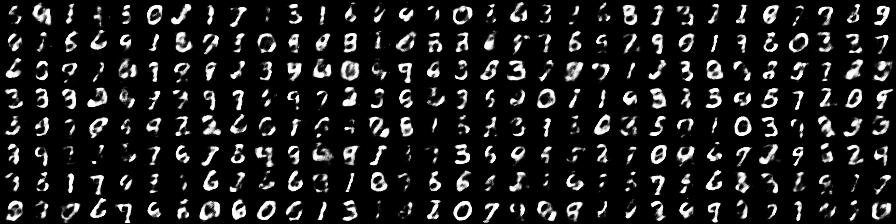

In [12]:
!convert -loop 0  -delay 30 data/lab14/*.jpg data/lab14/output.gif
from IPython.display import Image
Image('./data/lab14/output.gif')

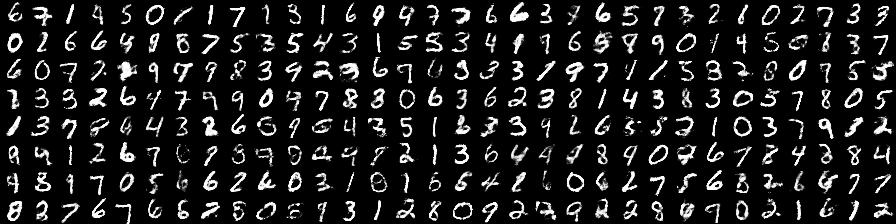

In [11]:
Image('./data/lab14/019.jpg')

# Report

107062566 Yu-Cheng Huang

## Learn

First, I thought TA's code is over-designed, so I decided to do it myself. I chosed Keras/Tensorflow as TA had sayed Pytorch is not allowed for LAB. But using such unfamiliar framework, I have been struggling to write a good performance WGAN-GP due to following reasons:

1. Keras is not compatible with tensorflow, although documents says so. Loss will be weired if using Keras layers inside a tensorflow model.
2. Discriminatior can't have sigmoid
3. Conv/Deconv is difficult to train, especially compared to FC-based model

After all, I finally got a fine result using FC-based model and I have kept my code clean and readable. You don't need too many class and code to construct such simple model.

## Application of GAN

1. Shoes style creation [link](https://arxiv.org/pdf/1703.05192.pdf)
2. Anime character createion [link](https://arxiv.org/pdf/1708.05509.pdf)
3. Style/Color transform [link](https://arxiv.org/pdf/1703.10593.pdf)
4. Super Resolution [link](https://arxiv.org/pdf/1609.04802.pdf)
5. Data Augmentation